<a href="https://colab.research.google.com/github/FritzAriza/TDG_Ariza_Roman/blob/main/prueba_modelo_TFLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Codigo hecho para probar un nuevo audio**

---

In [1]:
# Instalación de bibliotecas necesarias
%pip install tensorflow_io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 11.9 MB/s eta 0:00:00


In [2]:
# Importación de bibliotecas
import numpy as np
import soundfile as sf
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import matplotlib.pyplot as plt

In [3]:
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Cargar audio
def load_audio(file_path):
  sample_rate = 16000
  channels = 1
  audio_binary = tf.io.read_file(file_path)
  try:
    audio, original_sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=channels)
    audio = tf.cast(audio, tf.float32)
    if original_sample_rate != sample_rate:
      audio = tfio.audio.resample(audio, original_sample_rate.numpy(), sample_rate)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate
  except tf.errors.InvalidArgumentError as e:
    print(f"Error al decodificar {file_path}: {e}")
    return None, None

# Generar el espectrograma
def get_spectrogram(waveform):
    target_length = 8000
    waveform_length = tf.shape(waveform)[0]
    padding_length = tf.maximum(0, target_length - waveform_length)
    zero_padding = tf.zeros([padding_length], dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)

    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram

# Graficar el espectrograma
def plot_spectrogram(spectrogram, ax, title):
    log_spec = np.log(spectrogram.T)
    height, width = log_spec.shape
    X = np.linspace(0, width, num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_xlim([0, width])
    ax.set_title(title)

# Cargar modelo TFLite
def load_tflite_model(model_path):
  try:
    # Cargar el modelo TFLite
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    print("El modelo se cargó correctamente.")
    return interpreter
  except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    return None

In [24]:
# Predicción de un archivo de audio externo
def predict_external_audio(input_path, drive_path):
  data, samplerate = sf.read(input_path)
  output_path = './audio_fixed.wav'
  sf.write(output_path, data, samplerate)

  waveform, sample_rate = load_audio(output_path)

  spectrogram = get_spectrogram(waveform)

  spectrogram_path = './spectrogram.png'
  plt.imsave(spectrogram_path, spectrogram.numpy(), cmap='gray')

  fig, ax = plt.subplots()
  plot_spectrogram(spectrogram.numpy(), ax, 'Spectrogram 1')
  plt.show()

  pil_img = tf.keras.preprocessing.image.load_img(spectrogram_path, target_size=(32, 32), color_mode='grayscale')

  img_tensor = np.array(pil_img)
  img_tensor = img_tensor.reshape(1, 32, 32, 1)
  img_tensor = (img_tensor / 255.0) * 255 - 128
  img_tensor = img_tensor.astype(np.int8)

  # Cargar tensor
  interpreter = load_tflite_model(drive_path)

  # Obtener detalles del tensor
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  interpreter.set_tensor(input_details[0]['index'], img_tensor)

  interpreter.invoke()

  pred = interpreter.get_tensor(output_details[0]['index'])

  print(f"Matriz de predicciones: {pred}")

  pred_label = np.argmax(pred, axis=1)

  labels = ['abre', 'apaga', 'cierra', 'dime', 'enciende']

  if 0 <= pred_label[0] < len(labels):
    print(f"Predicción: {labels[pred_label[0]]}")
  else:
    print("Predicción no válida.")

In [25]:
input_path = '/content/drive/MyDrive/dataset/esp/rec_abre.wav'
drive_path = '/content/drive/MyDrive/dataset/modelo/mejor_modelo.tflite'

ipd.Audio(input_path, rate=16000)

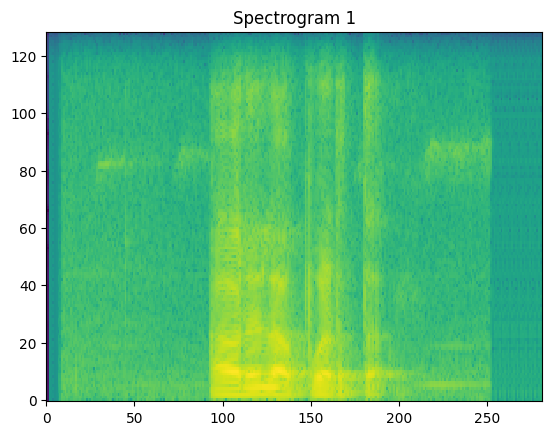

El modelo se cargó correctamente.
Matriz de predicciones: [[ 127 -127 -128 -128 -128]]
Predicción: abre


In [26]:
predict_external_audio(input_path, drive_path)

In [27]:
input_path = '/content/drive/MyDrive/dataset/esp/rec_apaga.wav'

ipd.Audio(input_path, rate=16000)

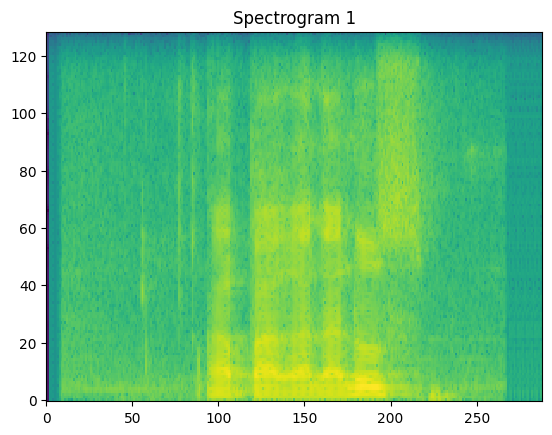

El modelo se cargó correctamente.
Matriz de predicciones: [[-128  127 -128 -128 -128]]
Predicción: apaga


In [28]:
predict_external_audio(input_path, drive_path)

In [29]:
input_path = '/content/drive/MyDrive/dataset/esp/rec_cierra.wav'

ipd.Audio(input_path, rate=16000)

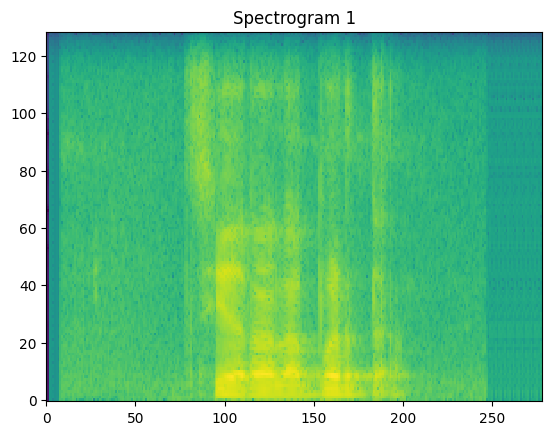

El modelo se cargó correctamente.
Matriz de predicciones: [[-128 -128  127 -128 -128]]
Predicción: cierra


In [30]:
predict_external_audio(input_path, drive_path)

In [31]:
input_path = '/content/drive/MyDrive/dataset/esp/rec_dime.wav'

ipd.Audio(input_path, rate=16000)

<ipython-input-4-9d8d61e6f215>:32: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


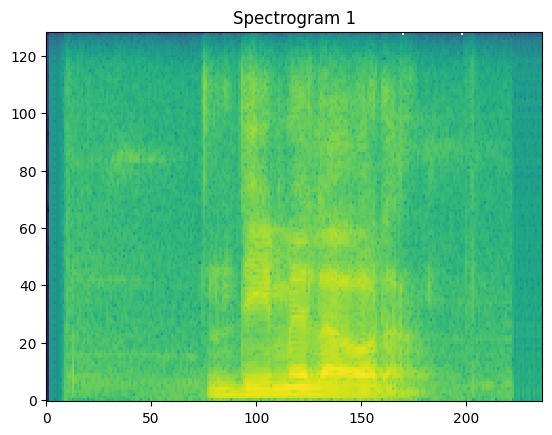

El modelo se cargó correctamente.
Matriz de predicciones: [[-128 -128 -128  127 -128]]
Predicción: dime


In [32]:
predict_external_audio(input_path, drive_path)

In [33]:
input_path = '/content/drive/MyDrive/dataset/esp/rec_enciende.wav'

ipd.Audio(input_path, rate=16000)

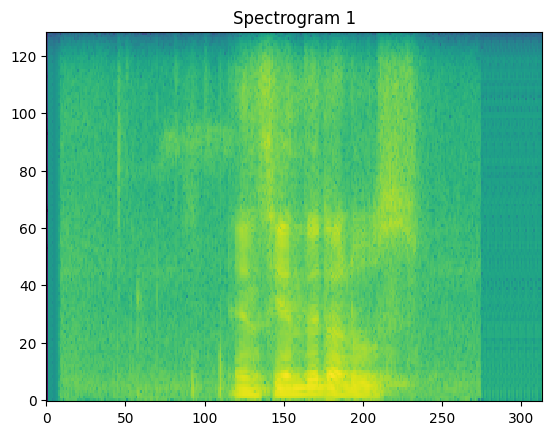

El modelo se cargó correctamente.
Matriz de predicciones: [[-128 -127 -128 -128  126]]
Predicción: enciende


In [34]:
predict_external_audio(input_path, drive_path)

In [35]:
input_path = '/content/drive/MyDrive/dataset/esp/rec.wav'

ipd.Audio(input_path, rate=16000)

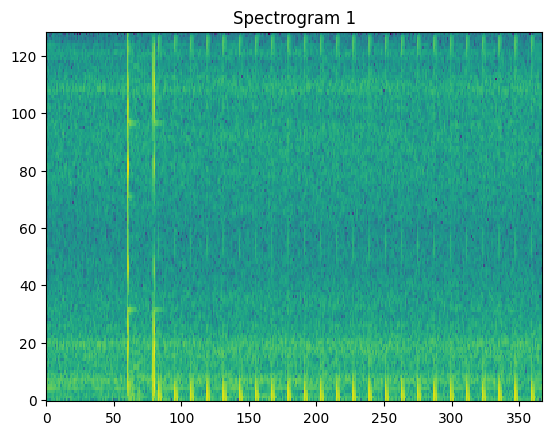

El modelo se cargó correctamente.
Matriz de predicciones: [[-126 -126  -87 -117   72]]
Predicción: enciende


In [36]:
predict_external_audio(input_path, drive_path)